## Precompute spectrograms for input to hawkears model and for quicker training cycles
The aim of this notebook is to develop a method for exporting the dataset  of spectrograms to disk. 

Additionally, it provides a method to get back from a pre-computed spectrogram to the original audio file on disk.



In [1]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import take_sample
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
import torch
import glob
import matplotlib.pyplot as plt

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load the dataframe from disk

In [2]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


## Set the output paths


In [3]:
train_present_save_path = Path.joinpath(data_path, "processed", "spectrograms", "train", "present")
train_absent_save_path = Path.joinpath(data_path, "processed", "spectrograms", "train", "absent")
valid_present_save_path = Path.joinpath(data_path, "processed", "spectrograms", "valid", "present")
valid_absent_save_path = Path.joinpath(data_path, "processed", "spectrograms", "valid", "absent")

save_paths = [train_present_save_path, train_absent_save_path, valid_present_save_path, valid_absent_save_path]
for path in save_paths:
    path.mkdir(parents=True, exist_ok=True)

Take a sample of the dataframe by recording.


In [4]:
df_train_sample = take_sample(df_train, 0.1)

sampled 5442 recordings from the original 54416 


# Turn the DataFrame into an AudioFileDataset
This uses the process in build.py to generate clip start and finish times for each of the downloaded recordings, and pairs the clips with their corresponding labels. No splitting of the audio is done here. A different train and validation set are generated each time the function is called. 

4 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    20745
1SPM     7546
None     4788
Name: count, dtype: int64
total recordings = 33079

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                   213.0          1476.0
1SPT                   265.0          3402.0
NaN                    107.0           275.0
total target clips =  585
total absence clips =  5153
total available human labelled target tags = 462
undefined 27341

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    3667
1SPM    1689
None     382
Name: count, dtype: int64
total recordings = 5738

Tags generated from each tagging method:
             target_presence  target_absence
task_method    

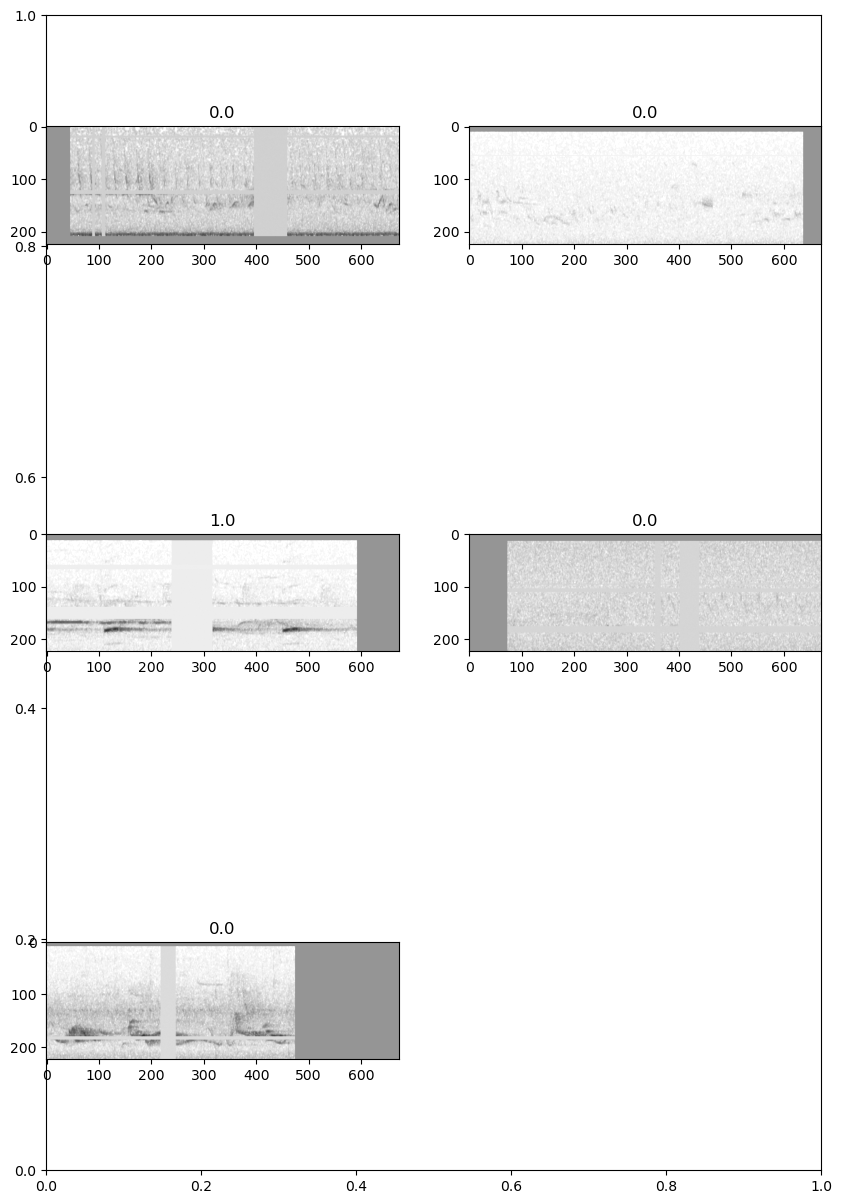

In [5]:
target_species = "OSFL"
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train_sample, target_species = target_species, download_n = 0, one_class=False)

# Downsample the absent class
We have access to much more data from the absent class than from the presence class, so downsampling allows the model to see more of the data from the presence class. 

In [6]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([465., 465.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([120., 120.])))

# Make datasets of presence and absence clips. 

In [7]:
train_present_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==1.0]
train_absent_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==0.0]
valid_present_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==1.0]
valid_absent_ds = train_dataset.label_df.loc[train_dataset.label_df.target_presence==0.0]

datasets = [train_present_ds, train_absent_ds, valid_present_ds, valid_absent_ds]

# Delete existing spectrograms if there are any

In [8]:
input(f"Warning, this will delete the files contained in {save_paths}.")
for ds, save_path in zip(datasets, save_paths):
    for file in save_path.iterdir():
        file.unlink()

# save the datasets as tensor spectrograms. 

In [9]:
def precompute_spectrograms(datasets, save_paths):
    for ds, save_path in zip(datasets, save_paths):
        for clip_index in ds.index:
            clip_path, start, end = clip_index
            filename = clip_path.parts[-1] + "-" + str(start) + "-" + str(end) + "-.pkl"
            audio = Audio.from_file(clip_path, offset=start, duration=end-start)
            spec = Spectrogram.from_audio(audio)
            im = spec.to_image(invert=False, return_type='torch')
            torch.save(im, save_path.joinpath(filename))
precompute_spectrograms(datasets, save_paths)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


# Define a function to get from the spectrogram back to the original audio file

In [10]:

def spec_to_audio(spec_filename, audio_path):
    '''Utility function to get from a precomputed spectrogram back to the same segment of the audio file.
    The filename of the spectrogram is used.
    Args:
        spec_filename (str): filename of the spectrogram
        audio_path (str): path to the audio files
    Returns:
        path (str): path to the source audio file
        offset (float): offset in seconds from beginning of the recording
        duration (str): duration of the clip in seconds.
'''
    _, rec_file, offset, end, _ = spec_filename.split("-")
    duration = float(end) - float(offset)
    path = Path(f"{audio_path}/recording-{rec_file}")
    return path, float(offset), duration

In [11]:
counter = 0

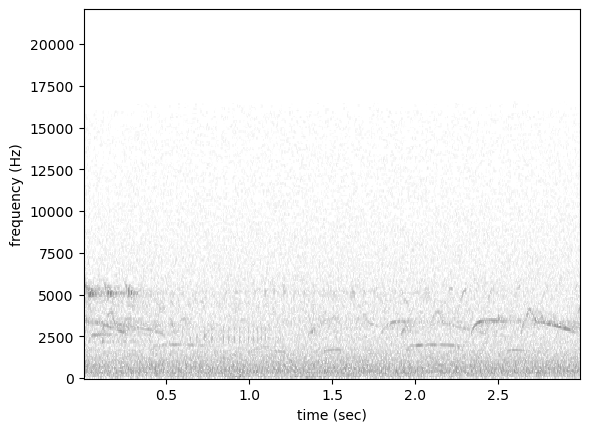

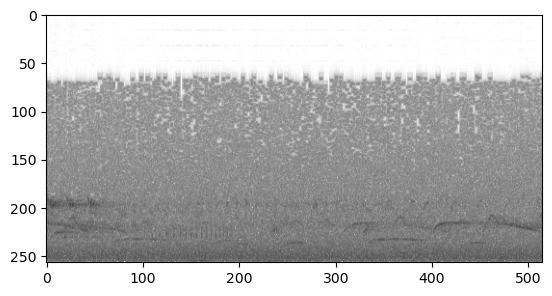

In [13]:
spec_path = train_present_save_path
spectrogram_file_paths = glob.glob(str(spec_path) + "/*")
spectrogram_file_names = [Path(p).parts[-1] for p in spectrogram_file_paths]

audio_path = train_present_ds.index[0][0].parent

counter+=1
path, start, duration = spec_to_audio(spec_filename=spectrogram_file_names[counter], audio_path=audio_path)

audio = Audio.from_file(path, offset=start, duration=duration)
spec = Spectrogram.from_audio(audio)
spec.plot() 
tensor = torch.load(spectrogram_file_paths[counter])
show_tensor(tensor)


# listen to the segment

In [14]:
audio

<Audio(samples=(132300,), sample_rate=44100)>

(PosixPath('../../data/raw/recordings/OSFL/recording-100730.flac'), 151.5, 3.0)
This spectrogram had some cool features in it. 

# test the amplitude plot function


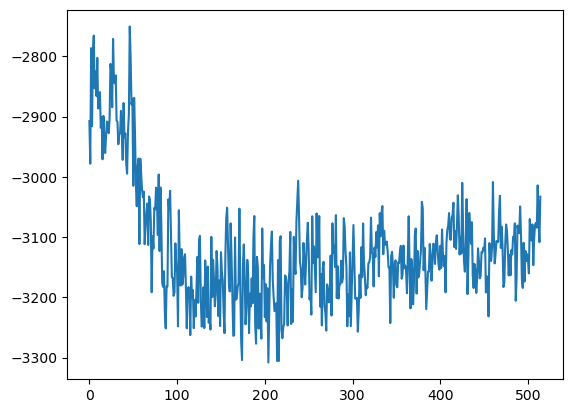

In [15]:
plt.plot(spec.amplitude(freq_range=(2500, 5500)))

In [16]:
# Generate an audio clips dataset
train_present_save_path = Path.joinpath(data_path, "processed", "audio_clips", "train", "present")
train_absent_save_path = Path.joinpath(data_path, "processed", "audio_clips", "train", "absent")
valid_present_save_path = Path.joinpath(data_path, "processed", "audio_clips", "valid", "present")
valid_absent_save_path = Path.joinpath(data_path, "processed", "audio_clips", "valid", "absent")

save_paths = [train_present_save_path, train_absent_save_path, valid_present_save_path, valid_absent_save_path]
for path in save_paths:
    path.mkdir(parents=True, exist_ok=True)

# Delete existing audio files if there are any

In [77]:
input(f"Warning, this will delete the files contained in {save_paths}.")
for ds, save_path in zip(datasets, save_paths):
    for file in save_path.iterdir():
        file.unlink()

# Save Some audio files

In [78]:
def save_audio_clips(datasets, save_paths):
    file_idx = 0


    for ds, save_path in zip(datasets, save_paths):
        for clip_index in ds.index:
            clip_path, start, end = clip_index
            file_idx +=1
            str_file_index = str(file_idx).zfill(5)
            filename = str_file_index + "-" + str(start) + "-" + str(end) + "-" + clip_path.parts[-1]
            audio = Audio.from_file(clip_path, offset=start, duration=end-start)
            audio.save(save_path.joinpath(filename))
save_audio_clips(datasets, save_paths)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:830: UserWarning: Saving metadata is only supported for WAV and AIFF formats
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:83